In [ ]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径

from itertools import chain


In [ ]:
# 读取Excel文件
excel_path = f'Concrete_Data.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='Sheet1') 
# print(df_sheet.info())
print(df_sheet.columns)


In [ ]:
# 输入输出参数
input_term = ['Cement ', 'Blast Furnace Slag ', 'Fly Ash ', 'Water  ',
            'Superplasticizer', 'Coarse Aggregate ', 'Fine Aggregate', 'Age']
output_term = ['Concrete compressive strength']
time_term= '主参数时间戳'


In [ ]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()

# 定义一个函数，用中位数替换异常值
def replace_outliers_with_median(series):
    # 计算列的中位数
    median_value = series.median()
    # 检测异常值
    outliers = (series - median_value).abs() > 3.0 * series.std()  # 使用标准差作为阈值
    # 使用中位数替换异常值
    series[outliers] = median_value
# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# replace_outliers_with_median(df_sheet_process[input_term[0]])
# replace_outliers_with_median(df_sheet_process[input_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[0]])
# replace_outliers_with_median(df_sheet_process[output_term[1]])
# replace_outliers_with_median(df_sheet_process[output_term[2]])
# replace_outliers_with_median(df_sheet_process[output_term[3]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




In [ ]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'g*-')
    plt.plot(data_x[index_predict],data_y[index_predict],'m-')
    
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签



# length1 = 300
# start1 = 430
# length2 = 300
# start2 = 230
# print((start2+length2-start1)/length2)
    

length1 = 400
start1 = 0
length2 = 400
start2 = 400
index_predict   = range(start1, start1+length1+1, 1)
index_gaolu     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [ ]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet[input_term[0]].values,
    input_term[1]:   df_sheet[input_term[1]].values,
    input_term[2]:   df_sheet[input_term[2]].values,
    input_term[3]:   df_sheet[input_term[3]].values,
    output_term[0]:  df_sheet[output_term[0]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [ ]:
# 标定归一化前后数据
data_point = np.array([1500]).reshape(-1, 1)
data1 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data1).reshape(-1, 1)
data2 = scalers[output_term[0]].inverse_transform(data_point).flatten()

data_point = np.array([1510]).reshape(-1, 1)
data3 = scalers[output_term[0]].transform(data_point).flatten()

data_point = np.array(data3).reshape(-1, 1)
data4 = scalers[output_term[0]].inverse_transform(data_point).flatten()

print(data1)
print(data2)
print(data3)
print(data4)
print('每摄氏度的输出差：',(data3-data1)/(data4-data2))



# data_point = np.array([0.5]).reshape(-1, 1)
# data1 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data1).reshape(-1, 1)
# data2 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# data_point = np.array([0.6]).reshape(-1, 1)
# data3 = scalers[output_term[1]].transform(data_point).flatten()

# data_point = np.array(data3).reshape(-1, 1)
# data4 = scalers[output_term[1]].inverse_transform(data_point).flatten()

# print(data1)
# print(data2)
# print(data3)
# print(data4)
# print('每0.01浓度的输出差：',(data3-data1))


In [50]:
# 组合训练数据--拆分训练、测试集
train_size = 0.7
val_size = 0.2
test_size = 0.1
def make_data(u1_data,u2_data,u3_data,u4_data,y1_data,test_size):
    u1_data = u1_data
    u2_data = u2_data
    u3_data = u3_data
    u4_data = u4_data

    u1_data_1 = np.roll(u1_data, 1)
    u2_data_1 = np.roll(u2_data, 1)
    u3_data_1 = np.roll(u3_data, 1)
    u4_data_1 = np.roll(u4_data, 1)

    y1_data = y1_data

    X = np.column_stack((   u1_data  [1:-1], u2_data  [1:-1], u3_data  [1:-1], u4_data  [1:-1],
                            u1_data_1[1:-1], u2_data_1[1:-1], u3_data_1[1:-1], u4_data_1[1:-1]
                            # ,
                            # y1_data  [1:-1]
                            )
                        )
    y = np.column_stack((y1_data[2:]))

    # 使用 reshape 转换形状(457, 10) (457, 2)--->(457, 1, 10) (457, 1, 2)
    X_reshaped = X.reshape((X.shape[0], 1, X.shape[1]))
    y_reshaped = y.reshape((y.shape[1], 1, y.shape[0]))
    print(y.shape)



    X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=True)
    
    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/train_size, 
                                                        random_state=42, 
                                                        shuffle=True)


    y_train = y_train.reshape((y_train.shape[0],y_train.shape[2]))
    y_val = y_val.reshape((y_val.shape[0],y_val.shape[2]))
    y_test = y_test.reshape((y_test.shape[0],y_test.shape[2]))
    print(X_train.shape,y_train.shape)
    print(X_val.shape,y_val.shape)
    print(X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [51]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
num_samples = y1_data.shape[0]



X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,y1_data,
                                        test_size=test_size)



(1, 399)
(256, 1, 8) (256, 1)
(103, 1, 8) (103, 1)
(40, 1, 8) (40, 1)


In [ ]:
plt.plot(u1_data,'g')
plt.plot(u2_data,'r')
plt.plot(u3_data,'m')
plt.plot(u4_data,'k')
# plt.plot(y1_data)
# plt.plot(y2_data)


In [52]:
# 定义LSTM模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,features_size,hidden_size,isbidirectional):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=features_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=isbidirectional
        )
        if isbidirectional:
            self.fc = nn.Linear(2 * hidden_size, 1)
        else:
            self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        
        return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse

    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train))
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_val))

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred.detach().numpy()


In [63]:
# 建立高炉模型实例
features_size = 8
hidden_size = 16
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=True)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []


In [64]:
# 高炉模型训练
epoch_once = 25
epoch_sum_gaolu = epoch_sum_gaolu+epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)


第 25/25 轮, 训练误差: 0.0018, 验证误差: 0.0023
epoch_sum: 25


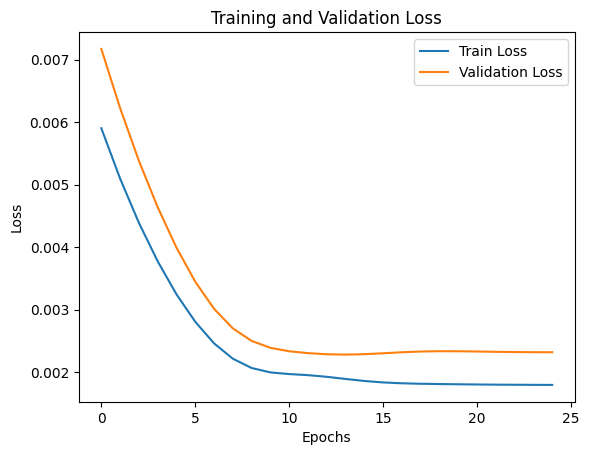

In [65]:
# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE: Concrete compressive strength: 12.2900
MRE : Concrete compressive strength: 0.5421
MAPE: Concrete compressive strength: 54.2058%
MAE:10.0766,RMSE:3.1744,HR:0.0250,RE:663.8250


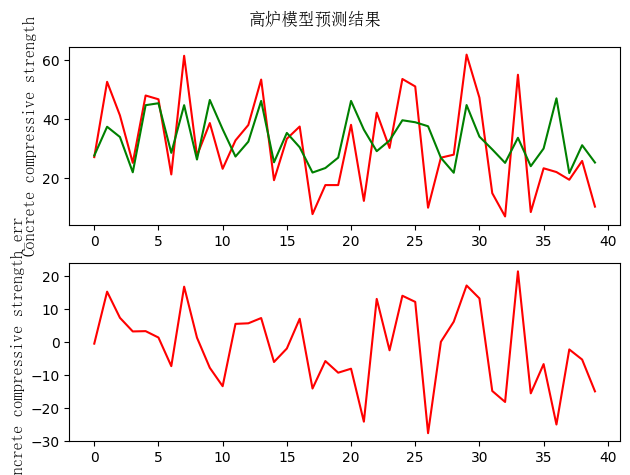

In [66]:
# 高炉模型预测
y_pred_0  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test

# y_test = y_test[:-1]
# y_pred_0 = y_pred_0[1:]

y_test_0 = scalers[output_term[0]].inverse_transform(y_test).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))

# 打印结果
print(f"RMSE: {output_term[0]}: {rmse_0:.4f}")
print(f"MRE : {output_term[0]}: { mre_0:.4f}")


output0 = y_test_0 - y_pred_0_inverse_transform
mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100

print(f"MAPE: {output_term[0]}: {mape_0:.4f}%")
MAE = np.mean(np.abs(output0))
RMSE = np.sqrt(MAE)
HR = np.sum(np.abs(output0)<0.1)/len(output0)
RE = np.sum(output0**2)/np.sum(y_gaolu_test**2)
print(f'MAE:{MAE:.4f},RMSE:{RMSE:.4f},HR:{HR:.4f},RE:{RE:.4f}')

plt.subplot(2, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签



plt.subplot(2, 1, 2)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签
plt.suptitle('高炉模型预测结果', fontproperties=font)  # 添加整个图形的标题

plt.tight_layout()

plt.show()



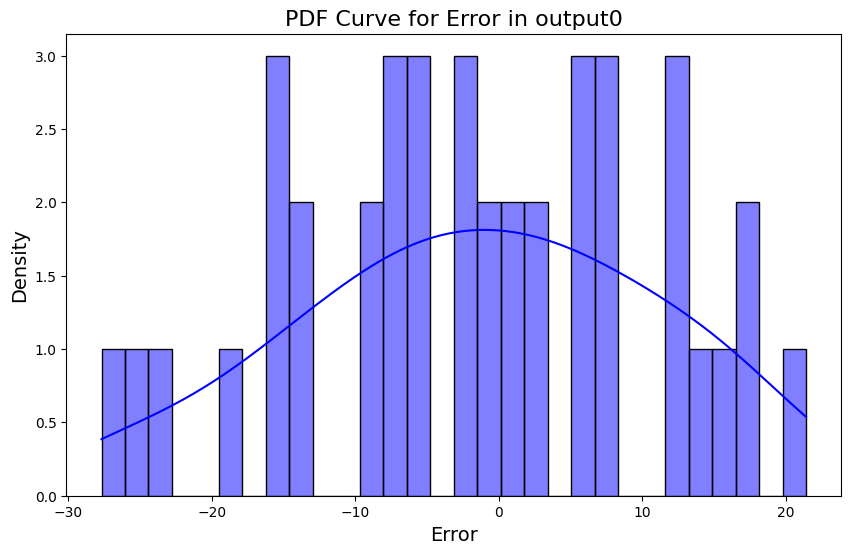

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# 使用 Seaborn 绘制误差的概率密度函数曲线
# sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(output0, kde=True, color="blue", bins=30)
plt.title("PDF Curve for Error in output0", fontsize=16)
plt.xlabel("Error", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()
